In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv2
from matplotlib import pyplot as plt
import imutils
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
import shapely.geometry as geometry

plotting_on = 1

In [2]:
# load and crop banners from image 
img = cv2.imread('/Users/matthewtoberman/Desktop/Frame_50_0mins_1secs_.jpg')
vert_crop_start = 90
#set pixel value of bottom of cropped image
vert_crop_end = img.shape[0]-75
# Crop frame
img = img[vert_crop_start:vert_crop_end, 0:-10]


In [3]:
#  CONVERT IMAGE TO GREYSCALE
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# apply canny edge detection algorithm
edges = cv2.Canny(img,8,200)

# find countours ie location of points of maxium gradient of canny edge 'image'
contours, hierarchy = cv2.findContours(edges, 
                            cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_NONE)[-2:]

# redraw these contours back onto the image for testing purpsoses
if plotting_on == 1:
    cv2.drawContours(img, contours, -1, (0,0,255), thickness = 2)



In [4]:
# compute concave hull method taken directly from https://github.com/dwyerk/boundaries/blob/master/concave_hulls.ipynb

# change contour to numpy array that shapely package is expecting.
list_of_pts = [] 
for ctr in contours:
    list_of_pts += [pt[0] for pt in ctr]

point_collection = geometry.MultiPoint(list_of_pts)
point_collection.envelope


def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set of points.

    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller
                  numbers don't fall inward as much as larger numbers. Too large,
                  and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = np.array([point.coords[0] for point in points])

    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

concave_hull, edge_points = alpha_shape(point_collection, alpha=0.01)



/Users/matthewtoberman/opt/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:14: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  
/Users/matthewtoberman/opt/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:27: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/Users/matthewtoberman/opt/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:60: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.


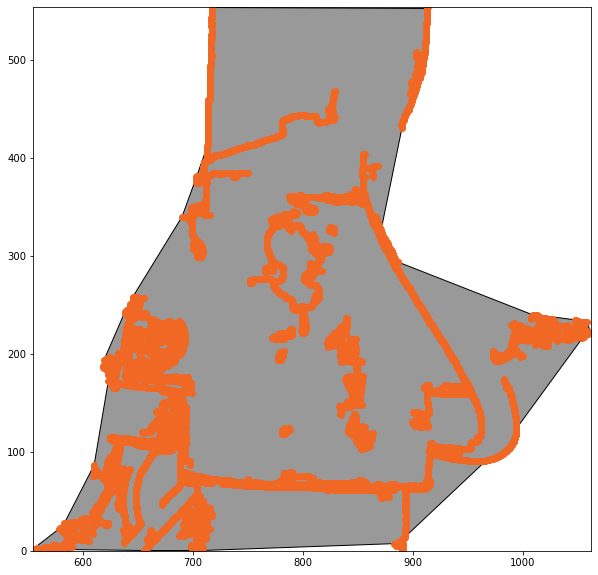

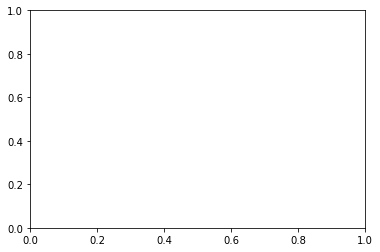

In [7]:
from descartes import PolygonPatch

def plot_polygon(polygon):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3

    x_min, y_min, x_max, y_max = polygon.bounds

    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999', ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)
    return fig


_ = plot_polygon(concave_hull)


ctr = np.array(list_of_pts).reshape((-1,1,2)).astype(np.int32)
ctr = np.squeeze(ctr)
ctr_x = [ctr[x][0] for x in range(len(ctr))]
ctr_y = [ctr[x][1] for x in range(len(ctr))]

_ = plt.plot(ctr_x,ctr_y,'o', color='#f16824')



# create an empty black image
drawing = np.zeros((edges.shape[0], edges.shape[1], 3), np.uint8)
drawing[:] = 255

fig, ax = plt.subplots()
plt.subplot(121),plt.imshow(img)
plt.plot(ctr_x,ctr_y,color='r', linewidth=4)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(drawing,cmap = 'gray')
plt.title('Edge Image')
plt.xticks([]), plt.yticks([])
ax = fig.add_subplot(111)
patch = PolygonPatch(concave_hull, fc='#999999', ec='#000000', fill=True, zorder=-1)
ax.add_patch(patch)

In [1]:
# # import shapely.geometry as geometry
# import shapely
# import alphashape
# from descartes import PolygonPatch
# from shapely.geometry import Polygon

# points  = geometry.MultiPoint(list_of_pts)



# alpha = 0.95 * alphashape.optimizealpha(points)
# hull = alphashape.alphashape(points, alpha)
# hull_pts = hull.exterior.coords.xy

# fig, ax = plt.subplots()
# ax.scatter(hull_pts[0], hull_pts[1], color='red')
# ax.add_patch(PolygonPatch(hull, fill=False, color='green'))

In [ ]:


# hull=cv2.convexHull(ctr, True)




# # hull = hull.tolist()
# # draw contours and hull points
# for i in range(len(hull)):
#     color_contours = (0, 255, 0) # green - color for contours
#     color = (0, 255, 0) # blue - color for convex hull
#     # draw ith contour
#     # cv2.drawContours(drawing, contours, i, color_contours, 1, 8, hierarchy)
#     # draw ith convex hull object
#     cv2.drawContours(drawing, hull, i, color, 1, 8)

# hull = np.squeeze(hull)
# hull_x = [hull[x][0] for x in range(len(hull))]
# hull_y = [hull[x][1] for x in range(len(hull))]

# ctr = np.squeeze(ctr)
# ctr_x = [ctr[x][0] for x in range(len(ctr))]
# ctr_y = [ctr[x][1] for x in range(len(ctr))]



# fig, ax = plt.subplots()
# # ax.scatter(hull_pts[0], hull_pts[1], color='red')
# # ax.add_patch(PolygonPatch(hull, fill=False, color='green'))

# plt.figure(figsize=(50, 10))
# plt.subplot(121),plt.imshow(img)
# plt.plot(hull_x,hull_y,color='r', linewidth=4)
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(drawing,cmap = 'gray')
# plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
# plt.fill(hull_x,hull_y)

# plt.show()